# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Select FRILL columns](#Select-FRILL-columns)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class linear discriminant analysis of FRILL embeddings](#One-class-linear-discriminant-analysis-of-FRILL-embeddings)
* [Local outlier factor of LDA components of FRILL embeddings](#Local-outlier-factor-of-LDA-components-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings and resultant LDA components](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Spherical coordinates](#Spherical-coordinates)
* [LDA components of spherical FRILL-based features](#LDA-components-of-spherical-FRILL-based-features)
* [One-class LDA components of spherical FRILL-based features](#One-class-LDA-components-of-spherical-FRILL-based-features)
* [Aggregate and scale](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

Three holdout datasets have been identified. This notebook featurizes them with the training data for final deployment.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from joblib import dump as joblib_dump, load as joblib_load
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# spherical coordinates
from numpy import arctan2, sqrt

# other sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM

# typing
from typing import Callable, List

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 4.54 s


# Setup

In [4]:
# Location of previously exported feature extractors
FEATURE_EXTRACTORS = "../26.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_poly_scores/feature_extractors"

# Location of newly exported feature extractors
RETRAINED_EXTRACTORS = "./feature_extractors"

# Location of holdout labels and FRILL columns
HOLDOUT = "../21.0-mic-prepare_holdout_datasets_for_evaluation"

# Location of training FRILL embeddings and labels
TRAINING_FRILL = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
OUT_FOLDER = "."

_ = gc_collect()

time: 119 ms


In [5]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}
VALENCES = ("neg", "neu", "pos")
NEIGHBORS = [20]
OC_SVM = ("sgdlinear", "rbf", "sigmoid")

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

feature_trio = lambda prefix, suffix: [
    f"{f'{prefix}_' if prefix else ''}{valence}{f'_{suffix}' if suffix else ''}"
    for valence in VALENCES
]

load_extractor = lambda feature_file: joblib_load(
    f"{FEATURE_EXTRACTORS}/{feature_file}.joblib"
)
save_extractor = lambda retrained_extractor, feature_file: joblib_dump(
    retrained_extractor, f"{RETRAINED_EXTRACTORS}/{feature_file}.joblib"
)


def spot_check(
    data: pd.DataFrame, labels: pd.DataFrame, expected_columns: List[str] = []
) -> None:
    """Spot check feature extraction process"""
    assert all(data.index == labels.index)
    assert not data.isnull().values.any()
    if expected_columns:
        assert list(data.columns) == expected_columns
    print(data.info())
    print(data.head())


_ = gc_collect()

time: 117 ms


In [6]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 100 ms


In [7]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 97.8 ms


In [8]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 106 ms


In [9]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{OUT_FOLDER}/holdout_{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 100 ms


# Load data

In [10]:
frill = pd.concat(
    [
        pd.read_feather(f"{HOLDOUT}/holdout_FRILL.feather"),
        pd.read_feather(f"{TRAINING_FRILL}/dev_FRILL.feather").drop(columns="id"),
        pd.read_feather(f"{TRAINING_FRILL}/nondev_FRILL.feather").drop(columns="id"),
    ]
).reset_index(drop=True)
labels = pd.concat(
    [
        pd.read_feather(path).drop(columns="id")
        for path in (
            f"{HOLDOUT}/holdout_labels.feather",
            f"{TRAINING_FRILL}/dev_labels.feather",
            f"{TRAINING_FRILL}/nondev_labels.feather",
        )
    ]
).reset_index(drop=True)
labels = labels.sample(frac=1, random_state=SEED + 5)
frill = frill.loc[labels.index, :]
spot_check(frill, labels)
frill = frill.reset_index(drop=True)
labels = labels.reset_index(drop=True)
spot_check(frill, labels)
YTRUE = labels.valence
YTRUE

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88709 entries, 38147 to 11955
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 693.7 MB
None
              0         1         2         3         4         5         6  \
38147 -0.024872  0.104527 -0.069726  0.093175  0.089265  0.010780 -0.049177   
7617   0.107346 -0.015504  0.031688 -0.078727 -0.063350 -0.013510  0.003956   
74227 -0.005502  0.075144  0.067945  0.031548  0.002621  0.058964  0.028664   
87689  0.053091  0.049761  0.007704 -0.062914 -0.011133  0.049159  0.041508   
5490   0.038791  0.015930  0.008256  0.004752 -0.026027 -0.002508 -0.003031   

              7         8         9  ...      2038      2039      2040  \
38147 -0.029323 -0.007976  0.142790  ...  0.042648  0.069436  0.031987   
7617   0.004843  0.086073 -0.090372  ... -0.110669 -0.136263  0.035456   
74227  0.049783  0.061557 -0.009204  ...  0.052700 -0.011908  0.084635   
87689  0.132686  0.100263 -0.087880  ... -0.004998  0.115515 -0.02

0        0
1        0
2        0
3        2
4        0
        ..
88704    1
88705    0
88706    0
88707    0
88708    0
Name: valence, Length: 88709, dtype: int8

time: 3.15 s


In [11]:
labels.reset_index(drop=True).to_feather(f"{OUT_FOLDER}/final_labels.feather")

time: 70.8 ms


# Select FRILL columns

In [12]:
with open(
    "../23.0-mic-train_new_prototypes_with_simplified_pipeline/selected_frill_columns.txt",
    "r",
) as f:
    selected_frill_columns = f.readlines()
selected_frill_columns = [line.strip() for line in selected_frill_columns]
frill = frill.loc[:, selected_frill_columns]
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Columns: 1024 entries, 0 to 2047
dtypes: float32(1024)
memory usage: 346.5 MB
None
          0         7        15        16        18        20        21  \
0 -0.024872 -0.029323  0.070840 -0.085156  0.146204 -0.043954 -0.038995   
1  0.107346  0.004843  0.111003 -0.037458  0.178338 -0.239939  0.021227   
2 -0.005502  0.049783  0.055659  0.017029 -0.129381  0.043878 -0.014931   
3  0.053091  0.132686 -0.159631  0.028744  0.393343  0.044491 -0.016789   
4  0.038791  0.032819  0.077706  0.036997  0.122630 -0.038550 -0.027724   

         22        30        32  ...      2023      2024      2026      2028  \
0 -0.016523  0.100104  0.002436  ...  0.016120 -0.026640 -0.073451  0.029412   
1 -0.062742  0.065855 -0.210651  ... -0.032549  0.005704  0.088484 -0.010796   
2 -0.010794 -0.021536 -0.043475  ...  0.041794  0.053806  0.009334 -0.036375   
3 -0.014757  0.009444 -0.021474  ...  0.012223 -0.027635  0.042530  0.

# Linear discriminant analysis components of FRILL embeddings

['./feature_extractors/LDA1_-_LDA2.joblib']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LDA1    88709 non-null  float64
 1   LDA2    88709 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB
None
       LDA1      LDA2
0  0.503588 -1.758739
1 -0.841017  0.180007
2  0.802681  0.301539
3 -0.154969  0.741741
4 -0.438905 -0.497244


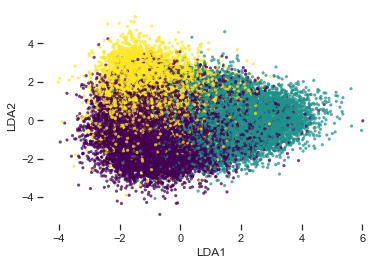

time: 23.1 s


In [13]:
features = ["LDA1", "LDA2"]
extractor = load_extractor("LDA1_-_LDA2").fit(frill, YTRUE)
save_extractor(extractor, "LDA1_-_LDA2")
data = pd.DataFrame(extractor.transform(frill), columns=features)
spot_check(data, labels)
plot2d(data, labels, *features)
checkpoint_features(data, features)

# One-class linear discriminant analysis of FRILL embeddings

['./feature_extractors/ocLDA_neg.joblib']

['./feature_extractors/ocLDA_neu.joblib']

['./feature_extractors/ocLDA_pos.joblib']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LDA1       88709 non-null  float64
 1   LDA2       88709 non-null  float64
 2   ocLDA_neg  88709 non-null  float64
 3   ocLDA_neu  88709 non-null  float64
 4   ocLDA_pos  88709 non-null  float64
dtypes: float64(5)
memory usage: 3.4 MB
None
       LDA1      LDA2  ocLDA_neg  ocLDA_neu  ocLDA_pos
0  0.503588 -1.758739   0.966262   0.404775  -1.780540
1 -0.841017  0.180007   0.414389  -0.829439   0.528183
2  0.802681  0.301539  -0.743676   0.817975  -0.084289
3 -0.154969  0.741741  -0.444847  -0.113402   0.725776
4 -0.438905 -0.497244   0.651116  -0.465764  -0.248692


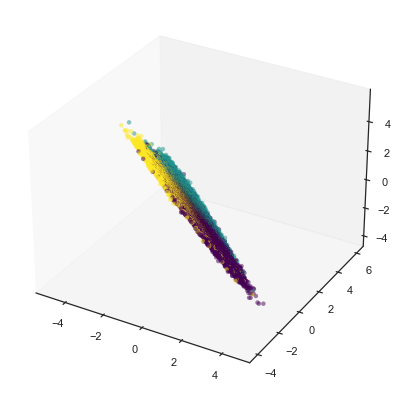

time: 1min 8s


In [14]:
df = deepcopy(frill)
features = []
for valence in VALENCES:
    feature = f"ocLDA_{valence}"
    x = df.loc[:, frill.columns]
    extractor = load_extractor(feature).fit(x, RECODER[valence](YTRUE))
    save_extractor(extractor, feature)
    df[feature] = np.squeeze(extractor.transform(x))
    features.append(feature)
    del feature
    _ = gc_collect()
data = pd.concat(
    [data, df.loc[:, feature_trio("ocLDA", "")]],
    axis="columns",
)
spot_check(data, labels)
plot3d(data, labels, *features)
checkpoint_features(data, features)

In [15]:
del df
_ = gc_collect()

time: 145 ms


# Local outlier factor of LDA components of FRILL embeddings

['./feature_extractors/LDA-LOF_neg_20.joblib']

['./feature_extractors/LDA-LOF_neu_20.joblib']

['./feature_extractors/LDA-LOF_pos_20.joblib']

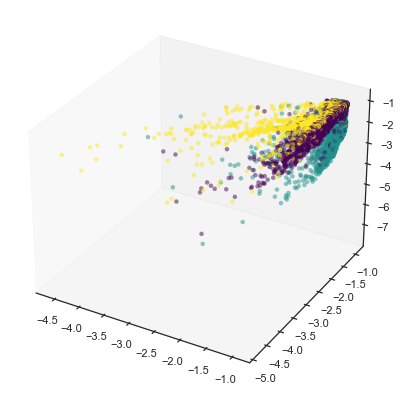

time: 4.07 s


In [16]:
n_neighbors = 20
for emo in ("neg", "neu", "pos"):
    valence = VALENCE[emo]
    key = f"LDA-LOF_{emo}_{n_neighbors}"
    data[key] = np.nan
    lof = LocalOutlierFactor(n_neighbors, novelty=True, n_jobs=-1).fit(
        data.loc[YTRUE == valence, ["LDA1", "LDA2"]].values
    )
    data.loc[YTRUE == valence, key] = lof.negative_outlier_factor_
    data.loc[YTRUE != valence, key] = lof.score_samples(
        data.loc[YTRUE != valence, ["LDA1", "LDA2"]].values
    )
    joblib_dump(lof, f"{RETRAINED_EXTRACTORS}/{key}.joblib")
    del valence
    del key
    del lof
    _ = gc_collect()
features = [
    f"LDA-LOF_neg_{n_neighbors}",
    f"LDA-LOF_neu_{n_neighbors}",
    f"LDA-LOF_pos_{n_neighbors}",
]
plot3d(data, labels, *features)
checkpoint_features(data, features)
del features
_ = gc_collect()

# One-class SVM scores of the LDA components of the FRILL embeddings

In [17]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, model_base: Callable, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print(
        f"extracting one-class {descriptor} scores of LDA components of FRILL embeddings..."
    )
    for valence in VALENCE.keys():
        feature = f"LDA-{prefix}_{valence}"
        classifier = model_base().fit(
            df.loc[YTRUE == VALENCE[valence], ["LDA1", "LDA2"]]
        )
        save_extractor(classifier, feature)
        df[feature] = classifier.score_samples(df.loc[:, ["LDA1", "LDA2"]])
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 151 ms


In [18]:
oc_svms = {
    "sgdlinear": lambda: SGDOneClassSVM(random_state=SEED + 7),
    "rbf": lambda: OneClassSVM(kernel="rbf", cache_size=300),
    "sigmoid": lambda: OneClassSVM(kernel="sigmoid", cache_size=300),
}
_ = gc_collect()

time: 144 ms


  0%|          | 0/3 [00:00<?, ?it/s]

extracting one-class sgdlinear scores of LDA components of FRILL embeddings...


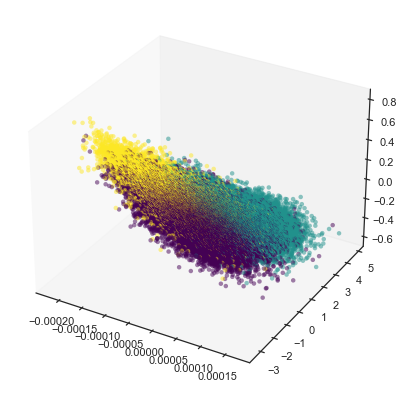

extracting one-class rbf scores of LDA components of FRILL embeddings...


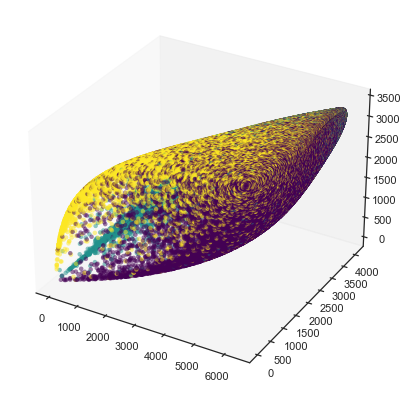

extracting one-class sigmoid scores of LDA components of FRILL embeddings...


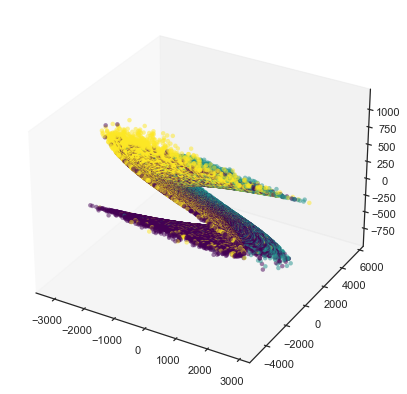

time: 17min 26s


In [19]:
for oc_svm, model_base in tqdm(oc_svms.items()):
    data = extract_ocsvm_features(data, labels, model_base, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings and resultant LDA components

['./feature_extractors/ocSVM_sgdlinear_neg.joblib']

['./feature_extractors/ocSVM_sgdlinear_neu.joblib']

['./feature_extractors/ocSVM_sgdlinear_pos.joblib']

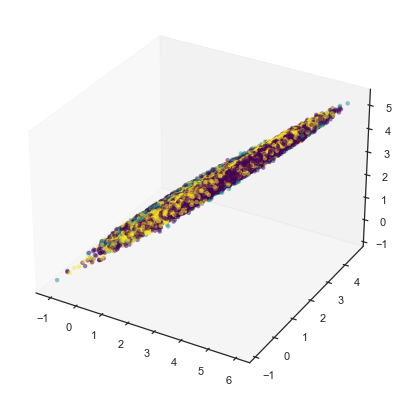

time: 6.57 s


In [23]:
prefix = f"ocSVM_sgdlinear"
for valence in VALENCE.keys():
    feature = f"{prefix}_{valence}"
    extractor = SGDOneClassSVM(random_state=SEED + 3, max_iter=10000).fit(
        frill.loc[YTRUE == VALENCE[valence]]
    )
    save_extractor(extractor, feature)
    data[feature] = extractor.score_samples(frill)
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
plot3d(data, labels, *features)
checkpoint_features(data, features)

['./feature_extractors/ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.joblib']

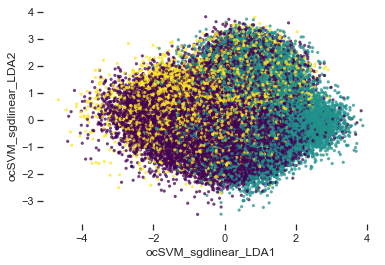

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     88709 non-null  float64
 1   LDA2                     88709 non-null  float64
 2   ocLDA_neg                88709 non-null  float64
 3   ocLDA_neu                88709 non-null  float64
 4   ocLDA_pos                88709 non-null  float64
 5   LDA-LOF_neg_20           88709 non-null  float64
 6   LDA-LOF_neu_20           88709 non-null  float64
 7   LDA-LOF_pos_20           88709 non-null  float64
 8   LDA-ocSVM_sgdlinear_neg  88709 non-null  float64
 9   LDA-ocSVM_sgdlinear_neu  88709 non-null  float64
 10  LDA-ocSVM_sgdlinear_pos  88709 non-null  float64
 11  LDA-ocSVM_rbf_neg        88709 non-null  float64
 12  LDA-ocSVM_rbf_neu        88709 non-null  float64
 13  LDA-ocSVM_rbf_pos        88709 non-null  float64
 14  LDA-ocSVM_sigmoid_neg 

In [24]:
prefix = "ocSVM_sgdlinear"
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
features_ = ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"]
extractor = LinearDiscriminantAnalysis().fit(data.loc[:, features], YTRUE)
save_extractor(extractor, "_-_".join(features_))
df = pd.DataFrame(extractor.transform(data.loc[:, features]), columns=features_)
df.index = labels.index
data = pd.concat([data, df], axis="columns")
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features_)
checkpoint_features(data, features_)
spot_check(data, labels)

# Spherical coordinates

In [25]:
features_ = [
    ["LDA1", "LDA2"],
    ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"],
    ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"],
    ["ocSVM_sgdlinear_neg", "ocSVM_sgdlinear_neu", "ocSVM_sgdlinear_pos"],
    ["LDA-LOF_neg_20", "LDA-LOF_neu_20", "LDA-LOF_pos_20"],
]

for descriptor in OC_SVM:
    features_.extend(
        [
            [
                f"LDA-ocSVM_{descriptor}_neg",
                f"LDA-ocSVM_{descriptor}_neu",
                f"LDA-ocSVM_{descriptor}_pos",
            ],
        ]
    )

all_features = []
for feature_set in features_:
    all_features.extend(feature_set)

_ = gc_collect()

time: 144 ms


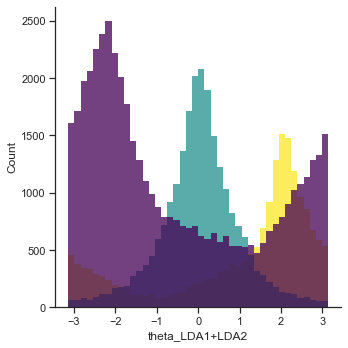

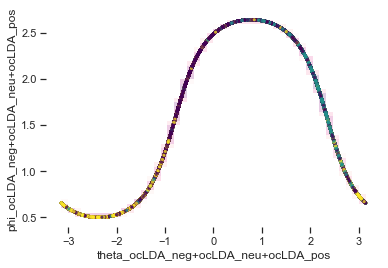

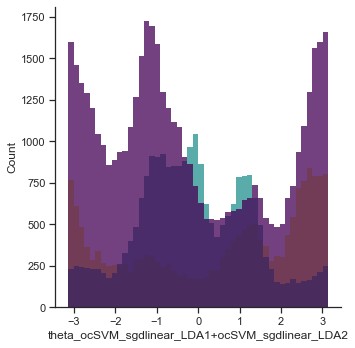

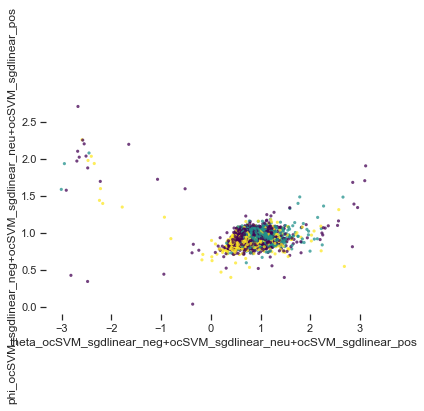

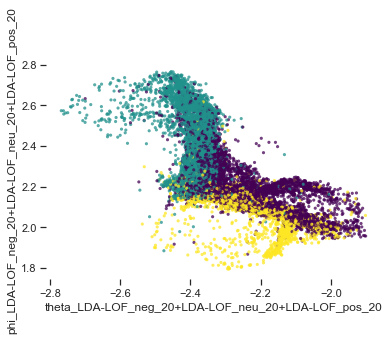

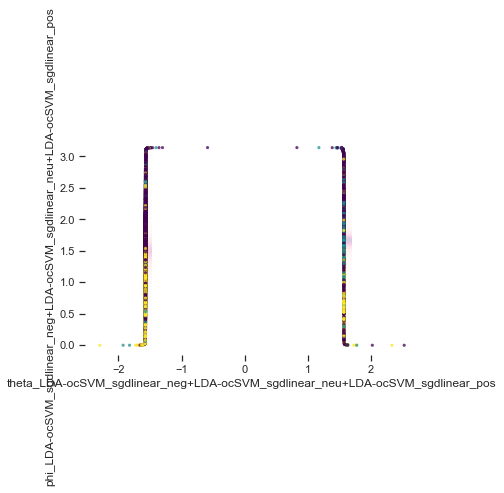

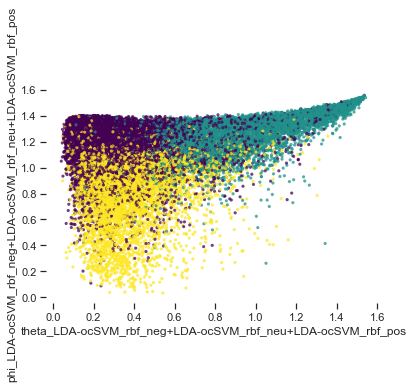

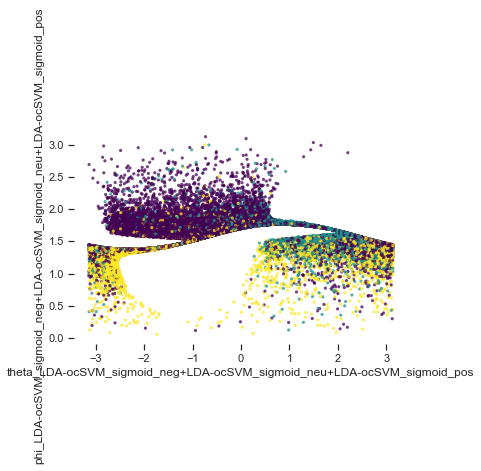

,theta_LDA1+LDA2,theta_ocLDA_neg+ocLDA_neu+ocLDA_pos,phi_ocLDA_neg+ocLDA_neu+ocLDA_pos,theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2,theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,theta_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20,phi_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20,theta_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,phi_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,theta_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,phi_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,theta_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,phi_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos
0,-1.291923,0.396700,2.609768,-2.737619,0.612693,0.950651,-2.331605,2.232888,1.570583,2.231553,0.486225,1.311221,0.427807,1.871382
1,2.930739,-1.107468,1.052986,-2.296479,0.548579,0.956409,-2.349790,2.175869,-1.570836,1.438736,0.403349,1.118734,-1.041940,1.496208
2,0.359353,2.308653,1.646894,1.512049,1.028211,0.871139,-2.357654,2.194292,1.570782,1.612215,0.589708,1.175304,2.290925,1.589821
3,1.776760,-2.891985,0.563995,2.994937,0.695148,0.912249,-2.349721,2.190287,-1.571103,0.728685,0.504871,1.124942,-2.916492,1.384534
4,-2.293957,-0.620942,1.871994,-1.247887,0.672412,1.009453,-2.363781,2.202059,-1.570781,1.638304,0.474223,1.150733,-0.708540,1.600493


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 14 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   theta_LDA1+LDA2                                                                88709 non-null  float64
 1   theta_ocLDA_neg+ocLDA_neu+ocLDA_pos                                            88709 non-null  float64
 2   phi_ocLDA_neg+ocLDA_neu+ocLDA_pos                                              88709 non-null  float64
 3   theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2                                88709 non-null  float64
 4   theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos              88709 non-null  float64
 5   phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos                88709 non-null  float64
 6   theta_LDA-LOF_neg_20+L

In [26]:
sphericals = {}
new_features = []
for features in features_:
    combo = "+".join(features)
    df = data.loc[:, features]
    x, y = df[features[0]], df[features[1]]
    theta, phi = f"theta_{combo}", f"phi_{combo}"
    sphericals[theta] = arctan2(y, x)
    all_features.append(theta)
    # convert to polar
    if len(features) == 3:
        sphericals[phi] = arctan2(sqrt(x ** 2 + y ** 2), df[features[2]])
        all_features.append(phi)
        plot2d(
            df := pd.DataFrame({theta: sphericals[theta], phi: sphericals[phi]}),
            labels,
            theta,
            phi,
        )
        assert not df.isnull().values.any()
        new_features.append([theta, phi])
    else:
        plot1d(df := pd.DataFrame({theta: sphericals[theta]}), labels, theta)
        assert not df.isnull().values.any()
        new_features.append([theta])
    del df
    del x
    del y
    del combo
    _ = gc_collect()
features_.extend(new_features)

sphericals = pd.DataFrame(sphericals)
sphericals.head()
sphericals.info()

In [27]:
assert all(sphericals.index == labels.index)
assert all(sphericals.index == data.index)
spot_check(data, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     88709 non-null  float64
 1   LDA2                     88709 non-null  float64
 2   ocLDA_neg                88709 non-null  float64
 3   ocLDA_neu                88709 non-null  float64
 4   ocLDA_pos                88709 non-null  float64
 5   LDA-LOF_neg_20           88709 non-null  float64
 6   LDA-LOF_neu_20           88709 non-null  float64
 7   LDA-LOF_pos_20           88709 non-null  float64
 8   LDA-ocSVM_sgdlinear_neg  88709 non-null  float64
 9   LDA-ocSVM_sgdlinear_neu  88709 non-null  float64
 10  LDA-ocSVM_sgdlinear_pos  88709 non-null  float64
 11  LDA-ocSVM_rbf_neg        88709 non-null  float64
 12  LDA-ocSVM_rbf_neu        88709 non-null  float64
 13  LDA-ocSVM_rbf_pos        88709 non-null  float64
 14  LDA-ocSVM_sigmoid_neg 

In [28]:
sphericals.columns = sphericals.columns.astype(str)
spot_check(sphericals, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 14 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   theta_LDA1+LDA2                                                                88709 non-null  float64
 1   theta_ocLDA_neg+ocLDA_neu+ocLDA_pos                                            88709 non-null  float64
 2   phi_ocLDA_neg+ocLDA_neu+ocLDA_pos                                              88709 non-null  float64
 3   theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2                                88709 non-null  float64
 4   theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos              88709 non-null  float64
 5   phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos                88709 non-null  float64
 6   theta_LDA-LOF_neg_20+L

# LDA components of spherical FRILL-based features

In [29]:
features = ["spherical-LDA1", "spherical-LDA2"]
extractor = load_extractor("_-_".join(features)).fit(sphericals, YTRUE)
save_extractor(extractor, "_-_".join(features))
df = pd.DataFrame(extractor.transform(sphericals), columns=features)
all_features.extend(features)
assert all(df.index == labels.index)
assert all(df.index == data.index)
_ = gc_collect()

['./feature_extractors/spherical-LDA1_-_spherical-LDA2.joblib']

time: 555 ms


In [30]:
df_ = pd.concat(
    [
        data,
        df,
    ],
    axis="columns",
)
spot_check(df_, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     88709 non-null  float64
 1   LDA2                     88709 non-null  float64
 2   ocLDA_neg                88709 non-null  float64
 3   ocLDA_neu                88709 non-null  float64
 4   ocLDA_pos                88709 non-null  float64
 5   LDA-LOF_neg_20           88709 non-null  float64
 6   LDA-LOF_neu_20           88709 non-null  float64
 7   LDA-LOF_pos_20           88709 non-null  float64
 8   LDA-ocSVM_sgdlinear_neg  88709 non-null  float64
 9   LDA-ocSVM_sgdlinear_neu  88709 non-null  float64
 10  LDA-ocSVM_sgdlinear_pos  88709 non-null  float64
 11  LDA-ocSVM_rbf_neg        88709 non-null  float64
 12  LDA-ocSVM_rbf_neu        88709 non-null  float64
 13  LDA-ocSVM_rbf_pos        88709 non-null  float64
 14  LDA-ocSVM_sigmoid_neg 

In [31]:
data = deepcopy(df_)
spot_check(data, labels)
del df
del df_
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     88709 non-null  float64
 1   LDA2                     88709 non-null  float64
 2   ocLDA_neg                88709 non-null  float64
 3   ocLDA_neu                88709 non-null  float64
 4   ocLDA_pos                88709 non-null  float64
 5   LDA-LOF_neg_20           88709 non-null  float64
 6   LDA-LOF_neu_20           88709 non-null  float64
 7   LDA-LOF_pos_20           88709 non-null  float64
 8   LDA-ocSVM_sgdlinear_neg  88709 non-null  float64
 9   LDA-ocSVM_sgdlinear_neu  88709 non-null  float64
 10  LDA-ocSVM_sgdlinear_pos  88709 non-null  float64
 11  LDA-ocSVM_rbf_neg        88709 non-null  float64
 12  LDA-ocSVM_rbf_neu        88709 non-null  float64
 13  LDA-ocSVM_rbf_pos        88709 non-null  float64
 14  LDA-ocSVM_sigmoid_neg 

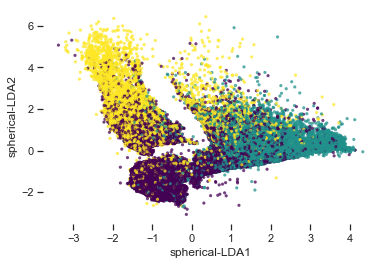

time: 2.34 s


In [32]:
plot2d(data, labels, *features)
checkpoint_features(data, features)

# One-class LDA components of spherical FRILL-based features

In [33]:
df = {}
for feature in feature_trio("spherical-ocLDA", ""):
    df[feature] = np.squeeze(
        (extractor := load_extractor(feature)).fit_transform(
            sphericals, RECODER[feature[-3:]](YTRUE)
        )
    )
    save_extractor(extractor, feature)

df = pd.concat([data, pd.DataFrame(df)], axis="columns")
spot_check(df, labels)
all_features.extend(feature_trio("spherical-ocLDA", ""))
_ = gc_collect()

['./feature_extractors/spherical-ocLDA_neg.joblib']

['./feature_extractors/spherical-ocLDA_neu.joblib']

['./feature_extractors/spherical-ocLDA_pos.joblib']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     88709 non-null  float64
 1   LDA2                     88709 non-null  float64
 2   ocLDA_neg                88709 non-null  float64
 3   ocLDA_neu                88709 non-null  float64
 4   ocLDA_pos                88709 non-null  float64
 5   LDA-LOF_neg_20           88709 non-null  float64
 6   LDA-LOF_neu_20           88709 non-null  float64
 7   LDA-LOF_pos_20           88709 non-null  float64
 8   LDA-ocSVM_sgdlinear_neg  88709 non-null  float64
 9   LDA-ocSVM_sgdlinear_neu  88709 non-null  float64
 10  LDA-ocSVM_sgdlinear_pos  88709 non-null  float64
 11  LDA-ocSVM_rbf_neg        88709 non-null  float64
 12  LDA-ocSVM_rbf_neu        88709 non-null  float64
 13  LDA-ocSVM_rbf_pos        88709 non-null  float64
 14  LDA-ocSVM_sigmoid_neg 

In [34]:
data = pd.concat([df, sphericals], axis="columns")
spot_check(data, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 41 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           88709 non-null  float64
 1   LDA2                                                                           88709 non-null  float64
 2   ocLDA_neg                                                                      88709 non-null  float64
 3   ocLDA_neu                                                                      88709 non-null  float64
 4   ocLDA_pos                                                                      88709 non-null  float64
 5   LDA-LOF_neg_20                                                                 88709 non-null  float64
 6   LDA-LOF_neu_20        

# Robust scaling

In [35]:
scaler = RobustScaler(unit_variance=True).fit(data)
save_extractor(scaler, "robust_scaler")
data = pd.DataFrame(scaler.transform(data), columns=scaler.feature_names_in_)
del scaler
_ = gc_collect()
spot_check(data, labels)

['./feature_extractors/robust_scaler.joblib']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 41 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           88709 non-null  float64
 1   LDA2                                                                           88709 non-null  float64
 2   ocLDA_neg                                                                      88709 non-null  float64
 3   ocLDA_neu                                                                      88709 non-null  float64
 4   ocLDA_pos                                                                      88709 non-null  float64
 5   LDA-LOF_neg_20                                                                 88709 non-null  float64
 6   LDA-LOF_neu_20        

In [36]:
data.columns = data.columns.astype(str)
data.reset_index(drop=True).to_feather(f"{OUT_FOLDER}/scaled_features.feather")
data = pd.read_feather(f"{OUT_FOLDER}/scaled_features.feather")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88709 entries, 0 to 88708
Data columns (total 41 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           88709 non-null  float64
 1   LDA2                                                                           88709 non-null  float64
 2   ocLDA_neg                                                                      88709 non-null  float64
 3   ocLDA_neu                                                                      88709 non-null  float64
 4   ocLDA_pos                                                                      88709 non-null  float64
 5   LDA-LOF_neg_20                                                                 88709 non-null  float64
 6   LDA-LOF_neu_20        

,LDA1,LDA2,ocLDA_neg,ocLDA_neu,ocLDA_pos,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-ocSVM_sgdlinear_neg,LDA-ocSVM_sgdlinear_neu,...,theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,theta_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20,phi_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20,theta_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,phi_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,theta_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,phi_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,theta_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,phi_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos
0,0.502684,-1.616935,0.816760,0.425135,-1.597999,0.858682,-0.247091,-2.797703,1.512596,0.424863,...,-1.167720,-0.558009,0.610432,2.248930,1.348834,2.787342,-0.090199,1.856394,0.407993,2.184485
1,-0.575116,0.208067,0.347137,-0.560945,0.576497,-0.538641,-0.265136,0.264410,-0.656544,-0.561028,...,-2.346510,-0.369899,-0.049153,-0.399241,-0.000072,-0.644175,-0.555051,-0.582558,-0.195605,-0.620860
2,0.742429,0.322469,-0.638333,0.755262,-0.000367,-0.065656,0.312333,-0.280614,0.155243,0.755162,...,6.471976,-3.155362,-0.334380,0.456367,1.348920,0.106688,0.490237,0.134227,1.173141,0.079123
3,-0.025198,0.736845,-0.384041,0.011136,0.762601,-0.479811,-0.236007,-0.588179,-0.695071,0.011089,...,0.348300,-1.812457,-0.046648,0.270392,-0.000186,-3.717457,0.014388,-0.503902,-0.965450,-1.455902
4,-0.252793,-0.429450,0.548583,-0.270385,-0.155211,-0.067384,0.557461,-0.584877,0.064117,-0.270533,...,-0.069736,1.362835,-0.556608,0.817135,-0.000048,0.219609,-0.157521,-0.177116,-0.058684,0.158925


time: 176 ms


# Discussion

Let's retrain and deploy!

In [37]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 2049.3345999717712 s
time: 141 ms


[^top](#Contents)